In [64]:
import pandas as pd
from datetime import time,date,datetime,timedelta
import requests

def get_data(ticker):
    import time 
    today_date = int(time.mktime(pd.Timestamp('2015-01-01').timetuple()))
    end_date = int(time.mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    ticker = ticker
    link = "https://services.entrade.com.vn/chart-api/chart?from={start_date}&resolution=1&symbol={ticker}&to={end_date}".format(start_date=today_date, ticker=ticker,end_date=end_date)
    f = requests.get(link)
    dict_f = f.json()
    import datetime
    df = pd.DataFrame()
    df['Date'] = dict_f['t']
    df['Date'] = pd.to_datetime(df['Date'].astype(int).apply(lambda x: datetime.datetime.fromtimestamp(x)))
    df['Close'] = dict_f['c']
    df['High'] = dict_f['h']
    df['Low'] = dict_f['l']
    df['Open'] = dict_f['o']
    df['Volume'] = dict_f['v']
    #df['day'] = df['Date'].dt.date
    df.set_index('Date', inplace=True)
    df = df.sort_values('Date')
    df.rename(columns= lambda col: col +" "+ ticker, inplace=True)
    return df

vn30f1m_df = get_data("VN30F1M")
vn30f2m_df = get_data("VN30F2M")
vn30f_df = vn30f1m_df.merge(vn30f2m_df, on='Date', how='left')
cols = ['Close VN30F2M', 'High VN30F2M', 'Low VN30F2M', 'Open VN30F2M']
for col in cols:
    vn30f_df[col]= vn30f_df[col].ffill()
vn30f_df['Volume VN30F2M'] = vn30f_df['Volume VN30F2M'].fillna(0)
print(vn30f_df)





                     Close VN30F1M  High VN30F1M  Low VN30F1M  Open VN30F1M  \
Date                                                                          
2018-08-13 09:00:00          942.9         943.5        942.9         943.5   
2018-08-13 09:01:00          943.1         943.1        942.9         943.0   
2018-08-13 09:02:00          943.5         943.6        943.0         943.0   
2018-08-13 09:03:00          943.4         943.4        943.3         943.3   
2018-08-13 09:04:00          943.1         943.2        943.0         943.2   
...                            ...           ...          ...           ...   
2023-03-23 14:27:00         1038.2        1038.4       1037.8        1037.8   
2023-03-23 14:28:00         1038.5        1038.5       1038.1        1038.3   
2023-03-23 14:29:00         1038.0        1039.0       1038.0        1038.5   
2023-03-23 14:30:00         1038.0        1038.0       1038.0        1038.0   
2023-03-23 14:45:00         1038.9        1038.9    

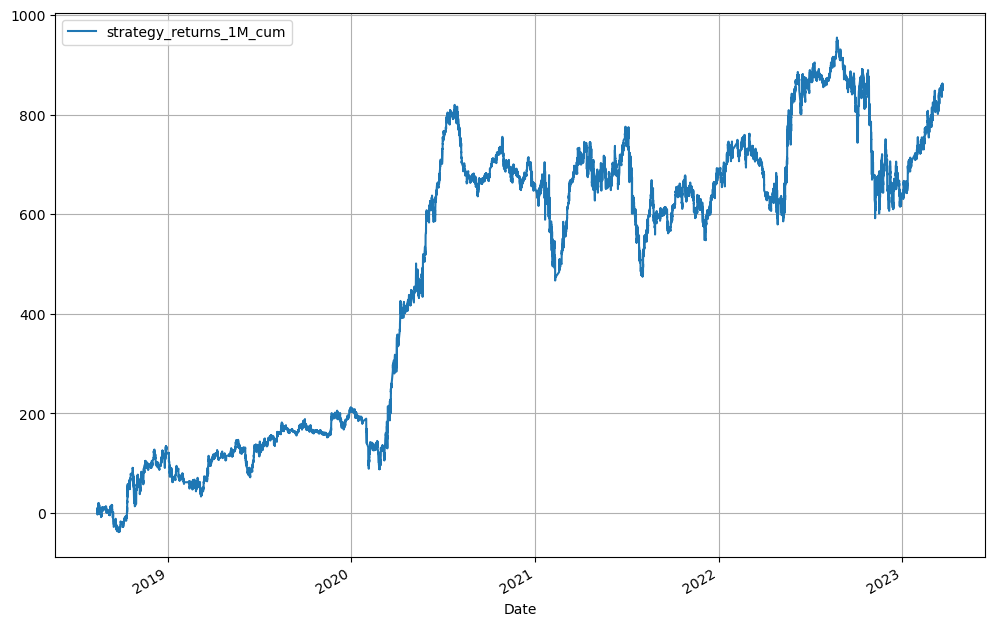

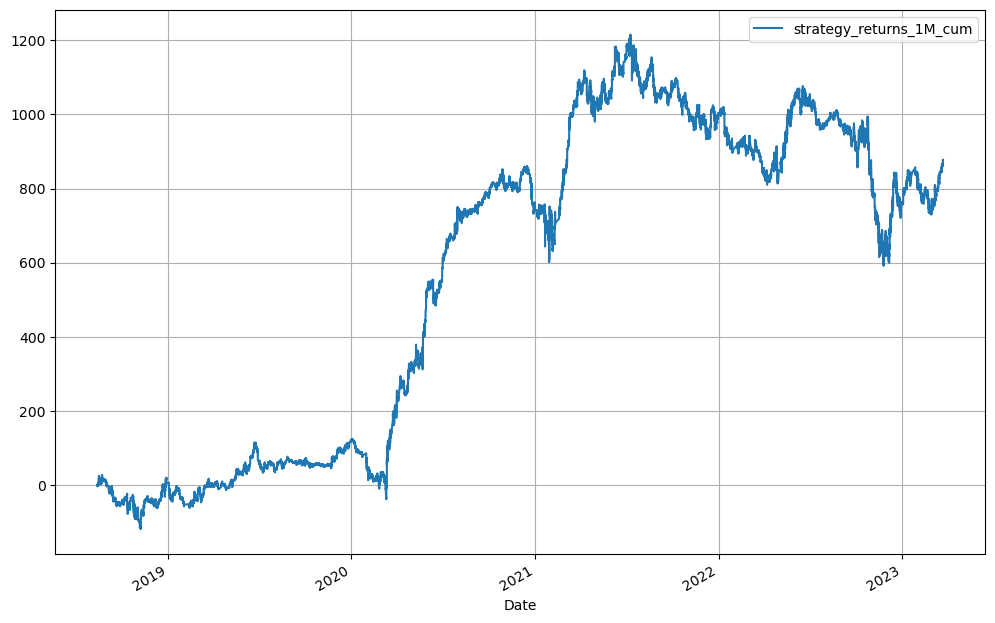

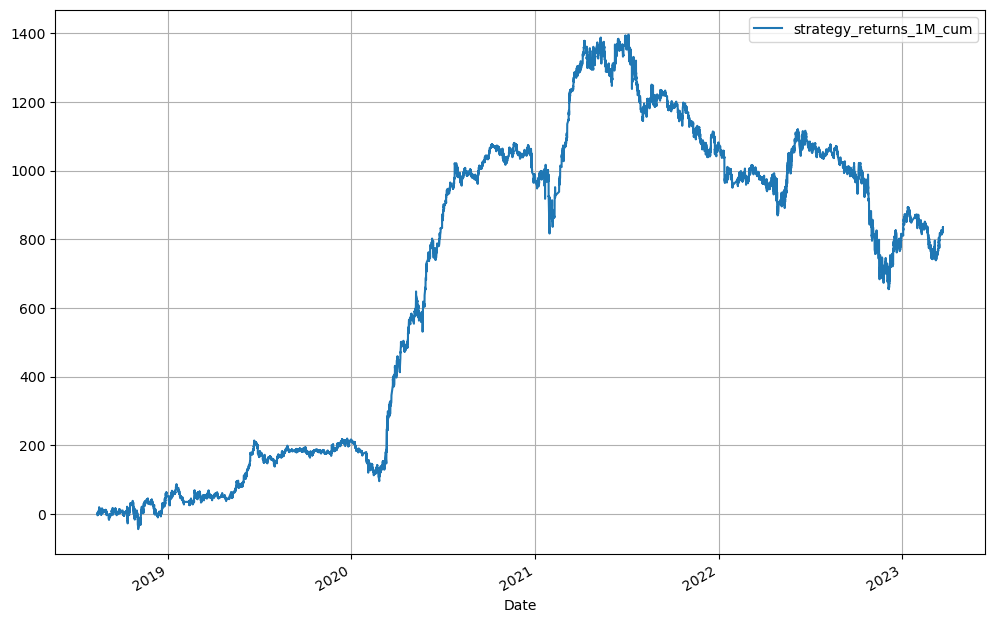

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

price_data = vn30f_df
price_data['spread'] = price_data['Close VN30F1M'] - price_data['Close VN30F2M']

price_data['bnh_returns'] = (price_data['spread']-price_data['spread'].shift(1))/(price_data['Close VN30F1M'].shift(1) + price_data['Close VN30F2M'].shift(1))

strat_window = [10,15,20]
for i in strat_window:
    price_data['ma20']=price_data['spread'].rolling(i).mean()
    price_data['std'] = price_data['spread'].rolling(i).std()
    price_data['upper_band'] = price_data['ma20'] + (2 * price_data['std'])
    price_data['lower_band'] = price_data['ma20'] - (2 * price_data['std'])

    price_data['signal'] = np.where((price_data['spread'] < price_data['lower_band']) &
                            (price_data['spread'].shift(1) >= price_data['lower_band']),1,0)

    price_data['signal'] = np.where( (price_data['spread'] > price_data['upper_band']) &
                              (price_data['spread'].shift(1) <= price_data['upper_band']),-1,price_data['signal'])

    price_data['position'] = price_data['signal'].replace(to_replace=0, method='ffill')

    price_data['position'] = price_data['position'].shift(1)

    price_data['strategy_returns'] = (price_data['spread']-price_data['spread'].shift(1)) * price_data['position']
    price_data['strategy_returns_1M'] = (price_data['Close VN30F1M'] - price_data['Close VN30F1M'].shift(1))* price_data['position']
    price_data['strategy_returns_2M'] = -(price_data['Close VN30F2M'] - price_data['Close VN30F2M'].shift(1))* price_data['position']

    price_data['bnh_returns_cum'] = (price_data['bnh_returns']+1).cumprod()
    price_data['strategy_returns_cum'] = price_data['strategy_returns'].cumsum()
    price_data['strategy_returns_1M_cum'] = price_data['strategy_returns_1M'].cumsum()
    price_data['strategy_returns_2M_cum'] = price_data['strategy_returns_2M'].cumsum()
    price_data[['strategy_returns_1M_cum']].plot(grid=True, figsize=(12, 8))





      Volume VN30F2M
0               11.0
1                0.0
2                0.0
3                0.0
4                1.0
...              ...
6634             0.0
6635             2.0
6636             1.0
6637             1.0
6638             1.0

[6639 rows x 1 columns]
2838
1037.6


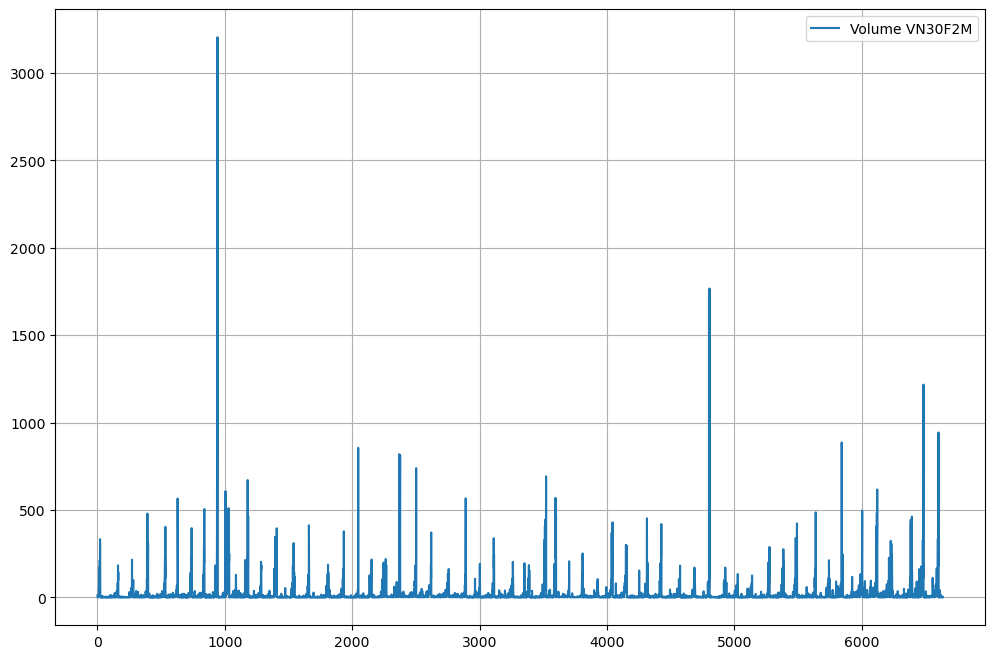

In [102]:
#liquidity check
abc = price_data.loc[(price_data['position']!=price_data['position'].shift(1))]
abc.reset_index(inplace=True)
abc[['Volume VN30F2M']].plot(grid=True, figsize=(12, 8))
count = 0
print(abc[['Volume VN30F2M']])
abc.reset_index(inplace=True)
for i in abc['Volume VN30F2M']:
    if abc.loc[i,'Volume VN30F2M']==0:
        count = count+1
print(count)
print(abc.iloc[-1]['Close VN30F1M'])

<AxesSubplot:>

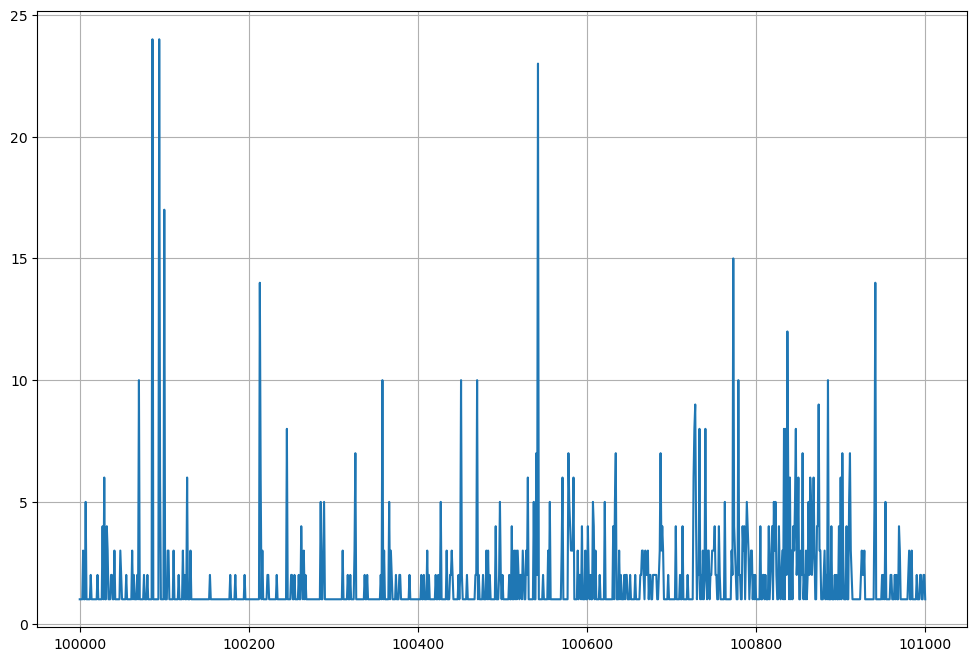

In [53]:
vn30f_2m_test = get_data("VN30F2M")
vn30f_2m_test.reset_index(inplace=True)
vn30f_2m_test.loc[100000:101000,"Volume VN30F2M"].plot(grid=True, figsize=(12, 8))

<AxesSubplot:>

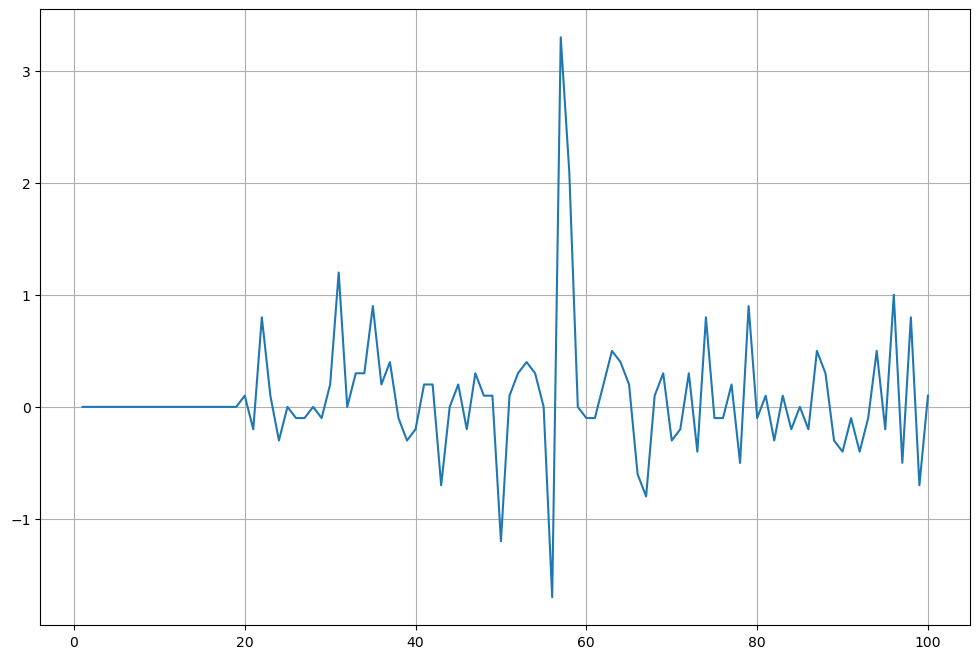

In [39]:
#price_data.reset_index(inplace=True)
price_data.loc[:100,'strategy_returns'].plot(grid=True, figsize=(12, 8))